# Fair Pricing of an Autocallable Barrier Reverse Convertible 

Monte Carlo method is applied to obtain the fair price of ABRC at Initial Fixing Date 
(i.e. last day of Subscription Period)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# retrieve daily lowest prices of CAT and DE from yahoo finance.
# prices are adjusted for dividends and stock splits
CAT = yf.Ticker("CAT")
DE  = yf.Ticker("DE")
cat = CAT.history(start='2018-04-16', end='2021-04-09', action=False).iloc[:,2:3]
de  = DE.history(start='2018-04-16', end='2021-04-09', action=False).iloc[:,2:3]
# calculate log returns
cat['Log_Return'] = np.log(cat['Low']/cat['Low'].shift(1))
de['Log_Return'] = np.log(de['Low']/de['Low'].shift(1))

In [2]:
# make sure that prices are quoted in USD
print(CAT.info['currency'])
print(DE.info['currency'])

USD
USD


In [2]:
cat

,Low,Log_Return
Date,,
2018-04-16,138.043057,NaN
2018-04-17,140.550750,0.018003
2018-04-18,141.983707,0.010144
2018-04-19,141.423391,-0.003954
2018-04-20,140.667547,-0.005359
...,...,...
2021-04-01,226.565854,-0.005521
2021-04-05,231.324344,0.020785
2021-04-06,229.193968,-0.009252


In [3]:
de

,Low,Log_Return
Date,,
2018-04-16,140.704683,NaN
2018-04-17,141.520706,0.005783
2018-04-18,141.767423,0.001742
2018-04-19,139.006266,-0.019669
2018-04-20,138.816475,-0.001366
...,...,...
2021-04-01,369.290009,0.002630
2021-04-05,373.910004,0.012433
2021-04-06,375.019989,0.002964


Text(0.5, 1.0, 'DE Adjusted Daily Lowest Price')

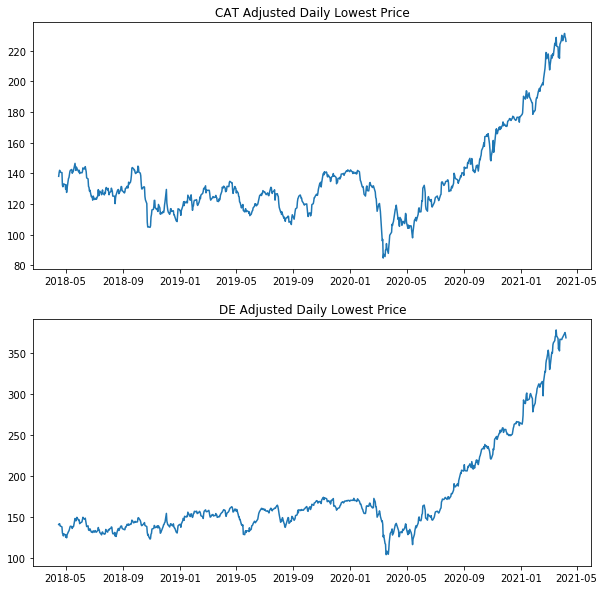

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2,1,figsize=(10,10))

axes[0].plot(cat['Low'])
axes[0].set_title('CAT Adjusted Daily Lowest Price')
axes[1].plot(de['Low'])
axes[1].set_title('DE Adjusted Daily Lowest Price')
# plt.show()

# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\historical_price.png')

C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Euler Ou\anaconda3\envs\eulerou\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Su

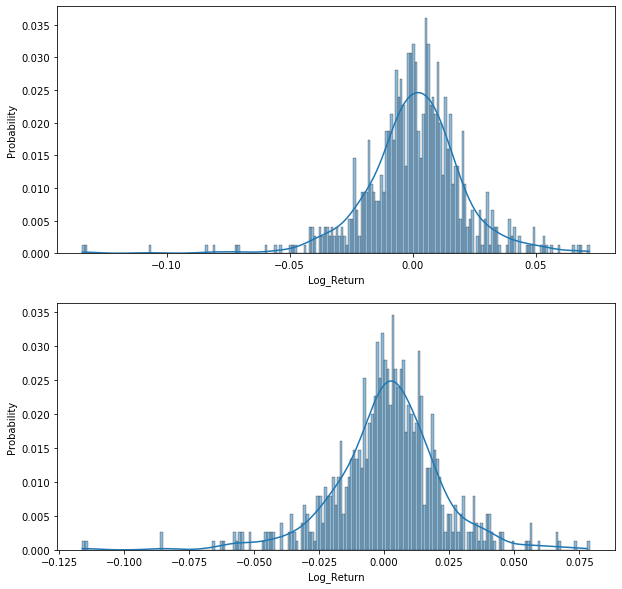

In [6]:
fig, axes = plt.subplots(2,1,figsize=(10,10))

sns.histplot(cat['Log_Return'], stat='probability', binwidth=0.001, kde=True, ax=axes[0])
sns.histplot(de['Log_Return'], stat='probability', binwidth=0.001, kde=True, ax=axes[1])

plt.show()

Assume that the adjusted daily lowest prices follow correlated Geometric Brownian Motion, now we calculate the drift and volatility of each underlying stock.

In [2]:
# Assume that there are in average 252 trading days in a year

# drift
mean1 = cat['Log_Return'].mean()
sig1 = np.nanstd(cat['Log_Return'], ddof=1)/np.sqrt(1/252)
mu1 = mean1*252 + 0.5*sig1**2

mean2 = de['Log_Return'].mean()
sig2 = np.nanstd(de['Log_Return'], ddof=1)/np.sqrt(1/252)
mu2 = mean2*252 + 0.5*sig2**2

print('Drift and Volatility of GBM of CAT: ', round(mu1,4), round(sig1,4),'\n')
print('Drift and Volatility of GBM of DE: ', round(mu2,4), round(sig2,4))
# correlation between log return

Drift and Volatility of GBM of CAT:  0.2203 0.33 

Drift and Volatility of GBM of DE:  0.3791 0.3333


In [3]:
# correlation
rho = np.corrcoef(cat['Log_Return'][1:], de['Log_Return'][1:])[0][1]
print('Correlation between log returns of CAT, DE: ', round(rho,4))

Correlation between log returns of CAT, DE:  0.7477


In [4]:
from datetime import datetime
import pandas_market_calendars as mcal # conda install -c conda-forge pandas_market_calendars

# get holidays in NYSE from Initial Fixing Date to Final Redemption Date
today, end_date = np.datetime64('2021-04-08'), np.datetime64('2022-07-15')
nyse = mcal.get_calendar('NYSE')
holidays = list(nyse.holidays().holidays) # as a list of datetime objects
holidays = [day for day in holidays if (day>=today) & (day <= end_date)]

# time to maturity (in trading days excluding holidays)
T = np.busday_count(today,end_date,holidays=holidays)

str_to_date = lambda date: datetime.strptime(date, '%Y-%m-%d').date()
# Trigger Observation Dates and Interest Payment Dates as lists of datetime.date objects
rdp_date = [str_to_date(date) for date in ['2021-10-12','2022-01-12','2022-04-12']]
cp_date = [str_to_date(date) for date in ['2021-07-15','2021-10-15','2022-01-18','2022-04-15','2022-07-15']]
sorted_date = sorted(rdp_date+cp_date)
# map trigger observation dates to the next redemption dates
early_rdp = lambda date: cp_date[rdp_date.index(date)+1]
# the next interest payment date for each early redemption
early_cp = list(map(early_rdp, rdp_date))

# counting function which returns relevent day counts
# For TOD, the day counts will be the number of trading days from today to TOD
# For IPD, it will be the number of days from today to IPD, excluding holidays
today = today.astype(datetime)
cpdaycount = lambda x: (x-today).days - len([day for day in holidays if (day.astype(datetime) <= x)])
daycount = lambda date: np.busday_count(today,date,holidays=holidays) if date in rdp_date else cpdaycount(date)

# how many days between consecutive trading days, excluding holidays 
# (for calculating discount factors under stochastic interest rate)
index = pd.date_range(start='4/8/2021', end='7/12/2022', freq='B').tolist()
index = [i for i in index if i not in holidays]
index = list(map(lambda x: x.date(), index))
interval = lambda x: (x[1]-x[0]).days - len([day for day in holidays if (day.astype(datetime) <= x[1])&(day.astype(datetime) >= x[0])])
dts = np.zeros(T-1)
for i in range(T-3):
    dts[i+1]= interval([index[i],index[i+1]])
dts = dts[1:]
dts[-1] = interval([index[-1], str_to_date('2022-07-15')])
dts = np.array([dts])

# Flat Interest Rate (23bps)

In [139]:
from math import floor
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # long-term risk-free interest rate
pr = 0.0825 # coupon rate
R1, R2 = 4.3388, 2.6733 # ratio of worst case scenario
trans = 0.0005 # transaction fee

N = 10**5 # number of simulation
# we need to simulate 1) daily lowest prices during barrier observation period (2021-4-9 to 2022-7-12)
# 2) final levels (closing prices on 2022-7-12)
# 3) settlement prices at maturity (2022-7-15)
# In the following, S1[i,:], S2[i,:] will be the vector of prices of each simulation on i-th business day after today
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
W1,W2,W3,W4 = np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N)
dt = 1/360
for i in range(T-3):
    S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
# daily lowest price at maturity
dt = 3/360
S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[-2,:])
S2[-1,:] = S2[-2,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[-2,:])
# adjustment from daily lowest prices to settlement prices
S1[-1,:] *= 1+abs(W1)
S2[-1,:] *= 1+abs(W2)
# adjustment for final level (from lowest prices to closing prices)
S1[-2,:] *= 1+abs(W3)
S2[-2,:] *= 1+abs(W4)
# values of redemption and cumulative coupon payments for each simulation
rdp, cp = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption at this time
        # if rdp==F, the simulated path has not been early redeemed at this TOD
        cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
    else:
        t = daycount(date)
        cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
        
# update the values at maturity
# condition of Barrier Event
barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2) 
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
# time to maturity (days)
t = daycount(cp_date[-1]) 
worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)

In [195]:
total = rdp+cp # total present value of cashflows of each simulation
price = np.mean(total)
var = np.var(total, ddof=1)/N

print('Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE): ', round(price,4))
print('Variance of the estimator: ', round(var,4))

Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE):  1045.014
Variance of the estimator:  0.0595


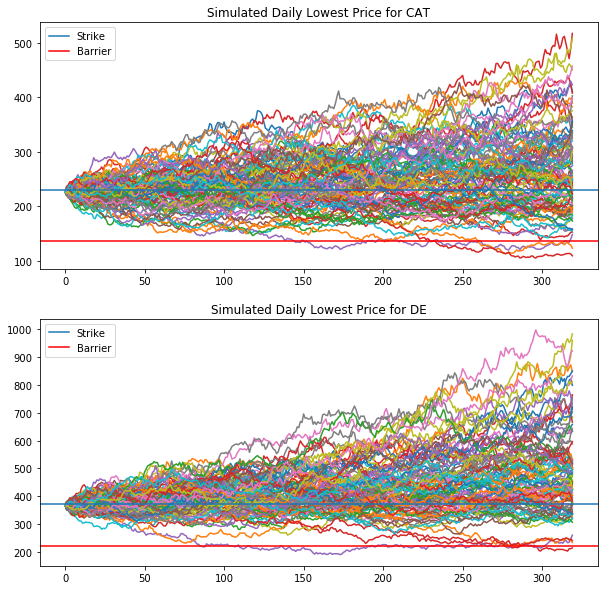

In [441]:
fig,axes = plt.subplots(2,1,figsize=(10,10))

axes[0].plot(S1[:,:100])
axes[0].axhline(X1, label='Strike')
axes[0].axhline(B1, color='r', label='Barrier')
axes[0].legend()
axes[0].set_title('Simulated Daily Lowest Price for CAT')

axes[1].plot(S2[:,:100])
axes[1].axhline(X2, label='Strike')
axes[1].axhline(B2, color='r', label='Barrier')
axes[1].legend()
axes[1].set_title('Simulated Daily Lowest Price for DE')

plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\simulated_price.png')

# Summary

In [ ]:
t = daycount(cp_date[-1]) # time to maturity (days)
early_index = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
early1 = np.where(rdp==F*np.exp(-r*daycount(cp_date[1])/360))
early2 = np.where(rdp==F*np.exp(-r*daycount(cp_date[2])/360))
early3 = np.where(rdp==F*np.exp(-r*daycount(cp_date[3])/360))
final_index = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
ok_index = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
worst_index = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario

print('Value of ABRC if:\n')
print('redeemed on Oct 15, 2021:', round(total[early1][0],4))
print('redeemed on Jan 18, 2022:', round(total[early2][0],4))
print('redeemed on Apr 15, 2022:', round(total[early3][0],4))
print('final redemption but no worst case scenario:', round(total[ok_index][0],4))

print('\nProbability of early redemption: ', len(early_index[0])/N)
print('Probability of redemption on Oct 15, 2021: ', len(early1[0])/N)
print('Probability of redemption on Jan 12, 2021: ', len(early2[0])/N)
print('Probability of redemption on Apr 15, 2021: ', len(early3[0])/N)
# print('Expected Value of the ABRC given final redemption: ', round(np.mean(total[early_index]),4))
# print('\nProbability of final redemption: ', len(final_index[0])/N)
# print('Expected Value of the ABRC given no early redemption: ', round(np.mean(total[final_index]),4))
# print('Probability of final redemption but not worst case scenario: ', (len(final_index[0])-len(worst_index[0]))/N)
# print('Expected Value of the ABRC given final redemption but no worst case scenario: ', round(np.mean(total[ok_index]),4))
print('\nProbability of Worst Case Scenario: ', len(worst_index[0])/N)
print('Expected Value of the ABRC given Worst Case Scenario: ', round(np.mean(total[worst_index]),4))

# Calculate fair prices of ABRC with a range of coupon rates

In [ ]:
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # interest rate
trans = 0.0005 # transaction fee

N = 10**5
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
# generate four normal r.v. for adjustment from daily lowest prices to final levels and settlement prices
W1 = abs(np.random.normal(0,0.01,N))
W2 = abs(np.random.normal(0,0.01,N))
W3 = abs(np.random.normal(0,0.01,N))
W4 = abs(np.random.normal(0,0.01,N))

def ABRC(pr):
    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+W1
    S2[-1,:] *= 1+W2
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+W3
    S2[-2,:] *= 1+W4

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    
    total = rdp+cp
    price = np.mean(total) # fair price
    var = np.var(total,ddof=1)/N # variance of estimator
    
    t = daycount(cp_date[-1]) # time to maturity (days)
    early = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
    final = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
    ok = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
    worst = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario
    
    p_early = np.mean(total[early])
    p_final = np.mean(total[final])
    p_ok = np.mean(total[ok])
    p_worst = np.mean(total[worst])

    return(price,var,p_early,p_final,p_ok,p_worst)

coupons = np.linspace(0.05,0.1,num=41)
result = [ABRC(x) for x in coupons]
prices = [i[0] for i in result]
variances = [i[1] for i in result]

In [302]:
plt.scatter(coupons,prices)
plt.title('Fair Price of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Fair Price')

# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\price_coupon.png')

NameError: name 'coupons' is not defined

In [ ]:
plt.scatter(coupons,variances)
plt.title('Variance of Estimator of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Variance of Estimator')

# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\variance_coupon.png')

# Control Variate

In [520]:
# We use the ABRC on only CAT as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S1[i,:]>=X1) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S1[:-1,:],axis=0)<=B1
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S1[-2,:]>=X1)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

Correlation between Product and ABRC with CAT: 0.916361246668472
ABRC price by control variate: 1045.9308
variance of the estimator: 0.0096


In [ ]:
# We use the ABRC on only DE as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S2[i,:]>=X2) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S2[:-1,:],axis=0)<=B2
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S2[-2,:]>=X2)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

# Antithetic Variate

In [ ]:
# face value
F = 1000
# strike price
X1 = 230.48
X2 = 374.07
# barrier price
B1 = X1*0.59
B2 = X2*0.59
# interest rate
r = 0.0023

N = 5*10**4
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
W1,W2,W3,W4 = np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01)
trans = 0.0005 # transaction fee

def ABRC(pr,Z1,Z2):
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+abs(W1)
    S2[-1,:] *= 1+abs(W2)
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+abs(W3)
    S2[-2,:] *= 1+abs(W4)

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    total = rdp+cp
    
    final_index = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations that reach final redemption
    pb_final = len(final_index[0])/N
    ev_final = np.mean(total[final_index]) # expected value of worst case scenario
    
    worst_index = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations for worst case scenario
    pb_worst = len(worst_index[0])/N
    ev_worst = np.mean(total[worst_index]) # expected value of final redemption
    
    summary = {'Probability of Final Redemption':round(pb_final,2), 'Expected Value of Final Redemption':round(ev_final,2),
               'Probability of Worst Case Scenario':round(pb_worst,3), 'Expected Value of Worst Case Scenario':round(ev_worst,2)}
    return(total, summary)

first = ABRC(pr=pr,Z1=Z1,Z2=Z2)
second = ABRC(pr=pr,Z1=Z1,Z2=-Z2)
prices1 = first[0]
prices2 = second[0]
corr = np.corrcoef(prices1,prices2)[0,1]
prices = np.concatenate((prices1,prices2))

print('Correlation between antithetic simulations:', corr)
print('ABRC price by antithetic variate:', np.mean(prices))
print('Variance of estimators:', np.var(prices,ddof=1)/len(prices))

# coupons = np.linspace(0.05,0.1,num=41)
# result = [ABRC(x) for x in coupons]

In [ ]:
# comparison of antithetic simulations
print(np.mean(prices1), np.mean(prices2))
print(first[1])
print(second[1])

# Stochastic Interest Rate (CIR)

In [5]:
# download three year data of U.S. 1Y Treasury rate
rate1 = pd.read_csv('C:/Users/Euler Ou/Dropbox/NCSU/2021 Spring/FIM 548/project/1Y Treasury.csv', parse_dates=['Date'], index_col=0)
rate2 = pd.read_csv('C:/Users/Euler Ou/Dropbox/NCSU/2021 Spring/FIM 548/project/1Y Treasury 2.csv', parse_dates=['Date'], index_col=0)
rate3 = pd.read_csv('C:/Users/Euler Ou/Dropbox/NCSU/2021 Spring/FIM 548/project/1Y Treasury 3.csv', parse_dates=['Date'], index_col=0)

In [6]:
# rate = pd.concat((rate3,rate2,rate1))
# rate = rate.iloc[:,-1]
rate = rate1.iloc[:,-1]
rate = rate.transform(lambda x: float(x[:-1])/100).values

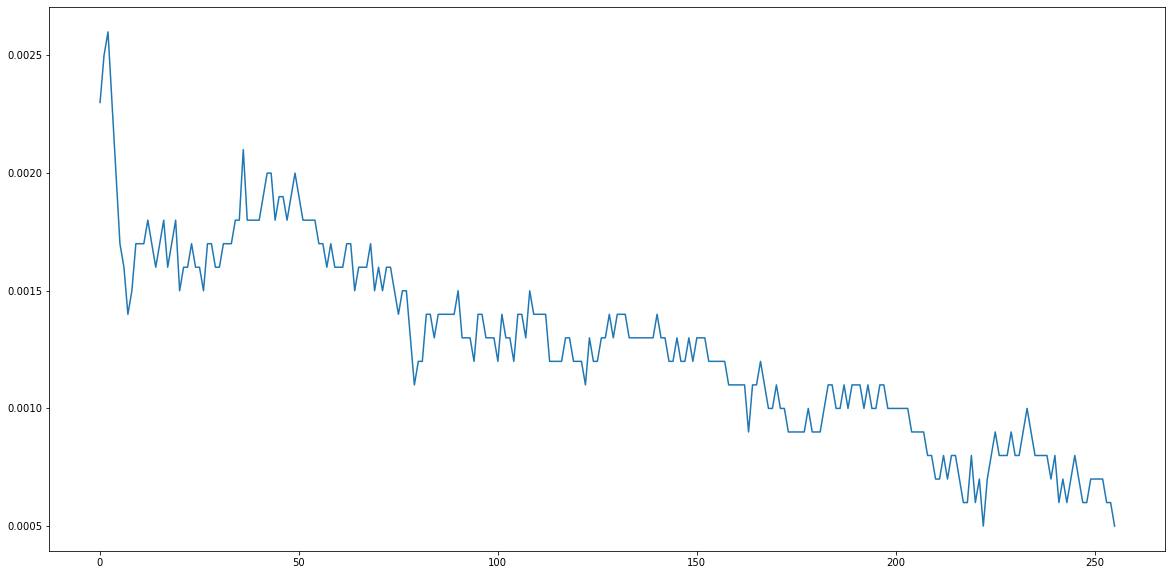

In [7]:
import matplotlib.pyplot as plt

plt.figure(num=1, figsize=(20, 10))
plt.plot(rate)


 parameter estimation

In [8]:
n = len(rate)
dt = 1/np.sqrt(252) # assume 252 trading days in a year
y = (rate[1:]-rate[:-1])/np.sqrt(np.maximum(rate[:-1],0))
z1 = dt/np.sqrt(rate[:-1])
z2 = dt*np.sqrt(rate[:-1])

Y = np.transpose(np.array([y]))
Z = np.transpose(np.vstack((np.array([z1]),np.array([z2]))))

beta = np.linalg.inv(Z.T @ Z) @ Z.T @Y
alpha = -beta[1,0]
mu = beta[0,0]/alpha

sig = np.sqrt(np.sum((Y - Z @ beta)**2)/(dt*n))

In [10]:
print(alpha,mu,sig)

0.616961853741037 0.0010905324252444254 0.011476787088441399


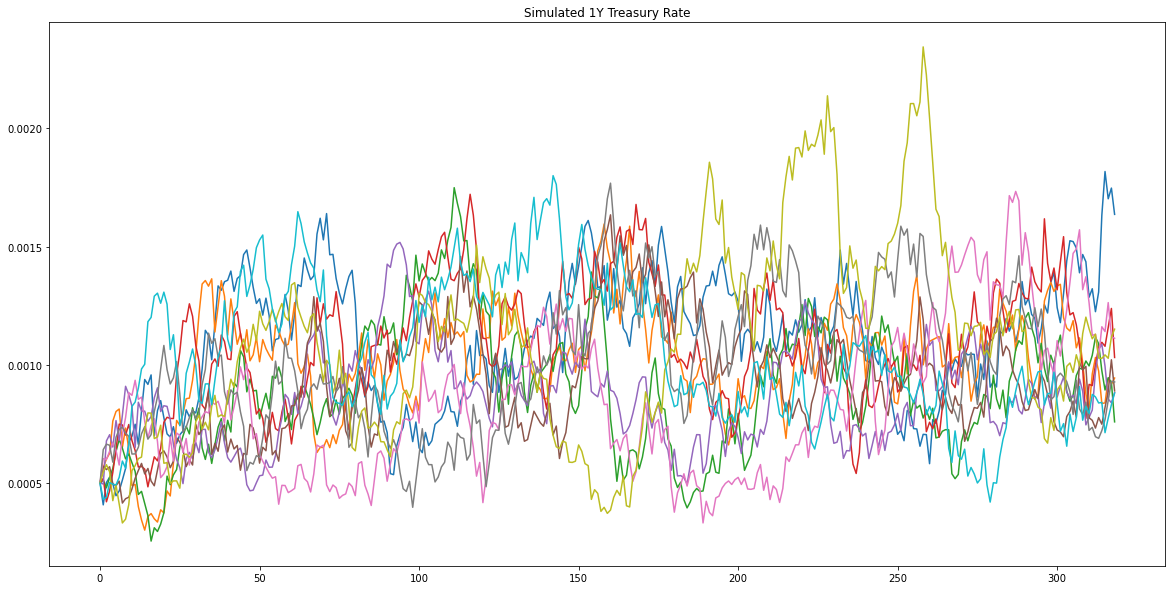

In [17]:
N = 100
r = np.ones((T-2,N))*rate[-1]
Zr = np.random.normal(0,1,size=(T-2,N)) # for CIR
for i in range(T-3):
    r[i+1,:] = r[i,:]+alpha*(mu-np.maximum(r[i,:],0))*dt+sig*np.sqrt(np.maximum(r[i,:],0)*dt)*Zr[i,:]
    
fig,ax = plt.subplots(1,figsize=(20,10))

ax.plot(r[:,:10])

ax.set_title('Simulated 1Y Treasury Rate')


plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\simulated_price.png')

# Fair Rricing

In [58]:
from math import floor
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
pr = 0.0825 # coupon rate
R1, R2 = 4.3388, 2.6733 # ratio of worst case scenario
trans = 0.0005 # transaction fee

N = 10**5 # number of simulation
# we need to simulate 1) daily lowest prices during barrier observation period (2021-4-9 to 2022-7-12)
# 2) final levels (closing prices on 2022-7-12)
# 3) settlement prices at maturity (2022-7-15)
# In the following, S1[i,:], S2[i,:] will be the vector of prices of each simulation on i-th business day after today
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
r = np.ones((T-2,N))*rate[-1]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
Zr = np.random.normal(0,1,size=(T-2,N)) # for CIR
W1,W2,W3,W4 = np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N)

dt = 1/360
for i in range(T-3):
    S1[i+1,:]=S1[i,:]*np.exp((mu1-r[i,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S2[i+1,:]=S2[i,:]*np.exp((mu2-r[i,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    r[i+1,:] = r[i,:]+alpha*(mu-np.maximum(r[i,:],0))*dt+sig*np.sqrt(np.maximum(r[i,:],0)*dt)*Zr[i,:]
# daily lowest price at maturity
dt = 3/360
S1[-1,:] = S1[-2,:]*np.exp((mu1-r[-2,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[-2,:])
S2[-1,:] = S2[-2,:]*np.exp((mu2-r[-2,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[-2,:])
# adjustment from daily lowest prices to settlement prices
S1[-1,:] *= 1+abs(W1)
S2[-1,:] *= 1+abs(W2)
# adjustment for final level (from lowest prices to closing prices)
S1[-2,:] *= 1+abs(W3)
S2[-2,:] *= 1+abs(W4)
# values of redemption and cumulative coupon payments for each simulation
rdp, cp = np.ones(N)*F, np.zeros(N)
# (used to identify the redemption type for each simulation)
early_index = np.zeros((3,N))

# update the values chronologically
for date in sorted_date[:-1]:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # trading days from today to this TOD
        j = np.busday_count(today,early_rdp(date),holidays=holidays) # trading days from today to Trigger Redemption Date
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
        # get the index of early redemption at this date
        early_index[cp_date.index(early_rdp(date))-1,:] = np.logical_and(rdp==F,condition)
        # discount factor from today to next IPD 
        discount = np.exp(-(dts[:,:j]@r[:j,:])*(1/360))[0] 
        # if rdp==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp += np.where(rdp==F, np.where(condition, F*0.25*pr*discount, 0), 0) 
        rdp = np.where(rdp==F, np.where(condition, rdp*discount, rdp), rdp)
    # if the date is an Interest Payment Date which is a Trigger Redemption Date
    elif date in early_cp:
        cp += np.where(rdp==F, F*0.25*pr*discount, 0)
    # if the date is an Interest Payment Date which is not a Trigger Redemption Date
    else:
        i = np.busday_count(today,date,holidays=holidays)
        discount = np.exp(-(dts[:,:i]@r[:i,:])*(1/360))[0]
        cp += np.where(rdp==F, F*0.25*pr*discount, 0)
        
# update the values at maturity
# condition of Barrier Event
barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2) 
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])

discount = np.exp(-(dts@r)*(1/360))[0]
worst_payoff = np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
final = (rdp==F)
cp += np.where(rdp==F, F*0.25*pr*discount, 0)
rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F, worst_payoff), F)*discount, rdp)

# print(rdp.shape,cp.shape)
total = rdp+cp # sum of present values of cashflows of each simulation

In [59]:
price = np.mean(total)
var = np.var(total, ddof=1)/N

print('Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE): ', round(price,4))
print('Variance of the estimator: ', round(var,4))

Fair price of the 8.25% Autocallable Barrier Reverse Convertibles (CAT, DE):  1046.905
Variance of the estimator:  0.061


In [60]:
# index of simulation for each redemption type
worst = np.logical_and.reduce([final,barrier,np.logical_not(barrier_full)])
ok = np.logical_and(final,np.logical_not(worst))

# early redemption, where each row is the early redemption in chronological order
early = np.array([list(map(bool,early_index[0])),
                       list(map(bool,early_index[1])),
                       list(map(bool,early_index[2]))])

# sum(np.sum(early_index,axis=0))/N

# Summary

In [61]:
print('Value of ABRC if:\n')
print('redeemed on Oct 15, 2021:', round(total[early[0]].mean(),4))
print('redeemed on Jan 18, 2022:', round(total[early[1]].mean(),4))
print('redeemed on Apr 15, 2022:', round(total[early[2]].mean(),4))
# print('final redemption but no worst case scenario:', round(total[ok_index][0],4))

print('\nProbability of early redemption: ', sum(np.sum(early_index,axis=0))/N)
print('Probability of redemption on Oct 15, 2021: ', sum(early[0])/N)
print('Probability of redemption on Jan 12, 2021: ', sum(early[1])/N)
print('Probability of redemption on Apr 15, 2021: ', sum(early[2])/N)
print('\nExpected Value of the ABRC given early redemption: ', round(np.mean(total[np.sum(early,axis=0)]),4))
print('\nProbability of final redemption: ', sum(final)/N)
print('Expected Value of the ABRC given final redemption: ', round(np.mean(total[final]),4))
print('\nProbability of final redemption but not worst case scenario: ', sum(ok)/N)
print('Expected Value of the ABRC given final redemption but no worst case scenario: ', round(np.mean(total[ok]),4))
print('\nProbability of Worst Case Scenario: ', sum(worst)/N)
print('Expected Value of the ABRC given Worst Case Scenario: ', round(np.mean(total[worst]),4))

Value of ABRC if:

redeemed on Oct 15, 2021: 1040.9494
redeemed on Jan 18, 2022: 1061.4038
redeemed on Apr 15, 2022: 1081.8462

Probability of early redemption:  0.71157
Probability of redemption on Oct 15, 2021:  0.51957
Probability of redemption on Jan 12, 2021:  0.12182
Probability of redemption on Apr 15, 2021:  0.07018

Expected Value of the ABRC given early redemption:  1046.8833

Probability of final redemption:  0.28843
Expected Value of the ABRC given final redemption:  1043.0077

Probability of final redemption but not worst case scenario:  0.243
Expected Value of the ABRC given final redemption but no worst case scenario:  1102.2801

Probability of Worst Case Scenario:  0.04543
Expected Value of the ABRC given Worst Case Scenario:  725.9662


In [65]:
# total[worst][:50]
S1[-2,worst][:50]

array([176.84034651, 106.37447424, 148.74154715, 133.08105883,
       213.62944383, 127.27127027, 133.93578404, 148.95150698,
       149.0042628 , 151.80089511, 158.26237352, 162.95680397,
       124.52644646, 128.36171385, 142.73972753, 143.62256039,
       143.73606491, 151.43793858, 136.44610277, 154.81537337,
       150.63885029, 148.43365239, 139.97959727, 111.70167038,
       196.10292423, 150.47403554, 127.30728148, 125.50161058,
       173.5839427 , 128.74383723, 216.12000698, 128.32288874,
       133.46500025, 141.45351386, 165.10107988, 122.29984835,
       130.37744406, 122.3060063 , 151.19415326, 135.97356215,
       158.33746064, 133.21635559, 170.92873965, 118.37834841,
       162.92844273, 135.24481138, 148.388066  , 120.57656778,
       192.41123356, 117.416922  ])

# Calculate fair prices of ABRC with a range of coupon rates

In [348]:
from math import floor
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
pr = 0.0825 # coupon rate
R1, R2 = 4.3388, 2.6733 # ratio of worst case scenario
trans = 0.0005 # transaction fee

N = 10**5 # number of simulation
# we need to simulate 1) daily lowest prices during barrier observation period (2021-4-9 to 2022-7-12)
# 2) final levels (closing prices on 2022-7-12)
# 3) settlement prices at maturity (2022-7-15)
# In the following, S1[i,:], S2[i,:] will be the vector of prices of each simulation on i-th business day after today
# S1 = np.ones((T-1,N))*cat.iloc[-1,0]
# S2 = np.ones((T-1,N))*de.iloc[-1,0]
# r = np.ones((T-2,N))*rate[-1]
# Z1 = np.random.normal(0,1,size=(T-2,N))
# Z2 = np.random.normal(0,1,size=(T-2,N))
# Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
# Zr = np.random.normal(0,1,size=(T-2,N)) # for CIR
# W1,W2,W3,W4 = np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N)

# S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
# S2 = np.ones((T-1,N))*de.iloc[-1,0]
# dt = 1/360
# for i in range(T-3):
#     S1[i+1,:]=S1[i,:]*np.exp((mu1-r[i,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
#     S2[i+1,:]=S2[i,:]*np.exp((mu2-r[i,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
#     r[i+1,:] = r[i,:]+alpha*(mu-np.maximum(r[i,:],0))*dt+sig*np.sqrt(np.maximum(r[i,:],0)*dt)*Zr[i,:]
# # daily lowest price at maturity
# dt = 3/360
# S1[-1,:] = S1[-2,:]*np.exp((mu1-r[-2,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[-2,:])
# S2[-1,:] = S2[-2,:]*np.exp((mu2-r[-2,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[-2,:])
# # adjustment from daily lowest prices to settlement prices
# S1[-1,:] *= 1+abs(W1)
# S2[-1,:] *= 1+abs(W2)
# # adjustment for final level (from lowest prices to closing prices)
# S1[-2,:] *= 1+abs(W3)
# S2[-2,:] *= 1+abs(W4)

def ABRC_stochastic(pr):
    S1 = np.ones((T-1,N))*cat.iloc[-1,0]
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    r = np.ones((T-2,N))*rate[-1]
    Z1 = np.random.normal(0,1,size=(T-2,N))
    Z2 = np.random.normal(0,1,size=(T-2,N))
    Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
    Zr = np.random.normal(0,1,size=(T-2,N)) # for CIR
    W1,W2,W3,W4 = np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N),np.random.normal(0,0.01,N)

    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-r[i,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-r[i,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
        r[i+1,:] = r[i,:]+alpha*(mu-np.maximum(r[i,:],0))*dt+sig*np.sqrt(np.maximum(r[i,:],0)*dt)*Zr[i,:]
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-r[-2,:]-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[-2,:])
    S2[-1,:] = S2[-2,:]*np.exp((mu2-r[-2,:]-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[-2,:])
    # adjustment from daily lowest prices to settlement prices
    S1[-1,:] *= 1+abs(W1)
    S2[-1,:] *= 1+abs(W2)
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+abs(W3)
    S2[-2,:] *= 1+abs(W4)
    
    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # (used to identify the redemption type for each simulation)
    early_index = np.zeros((3,N))

    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # trading days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to Trigger Redemption Date, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # get the index of early redemption at this date
            early_index[cp_date.index(early_rdp(date))-1,:] = np.logical_and(rdp==F,condition)
            # discount factor from today to Trigger Redemption Date 
            discount = np.exp(-(dts[:i]@r[:i,:])*(1/360)-r[i,:]*interval([date,early_rdp(date)])) 
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*discount, 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*discount, rdp), rdp)
        # if the date is an Interest Payment Date which is a Trigger Redemption Date
        elif date in early_cp:
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)
        # if the date is an Interest Payment Date which is not a Trigger Redemption Date
        else:
            i = np.busday_count(today,date,holidays=holidays)
            discount = np.exp(-(dts[:i]@r[:i,:])*(1/360))
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)

    # update the values at maturity
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2) 
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    # index of simulations with final redemption
    final = (rdp==F)
    
    discount = np.exp(-(dts@r)*(1/360))
    worst_payoff = np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    # condition of each redemption type
    early = np.array([list(map(bool,early_index[0])),
                       list(map(bool,early_index[1])),
                       list(map(bool,early_index[2]))])
    
    worst = np.logical_and.reduce([final,barrier,np.logical_not(barrier_full)])
    ok = np.logical_and(final,np.logical_not(worst))
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F, worst_payoff), F)*discount, rdp)
    
    total = rdp+cp

    p_early = np.mean(total[early.sum(axis=0)])
    p_final = np.mean(total[final])
    p_ok = np.mean(total[ok])
    p_worst = np.mean(total[worst])
    pb_worst = len(worst)/N
    
    price = total.mean()
    var = np.var(total,ddof=1)/N

    return(price,var,p_early,p_final,p_ok,p_worst,pb_worst)



In [349]:
coupons = np.linspace(0.05,0.1,num=41)
result = [ABRC_stochastic(pr) for pr in coupons]
prices = [i[0] for i in result]
variances = [i[1] for i in result]
chance_worst = result[0][-1]
worst_value = [i[-2] for i in result]

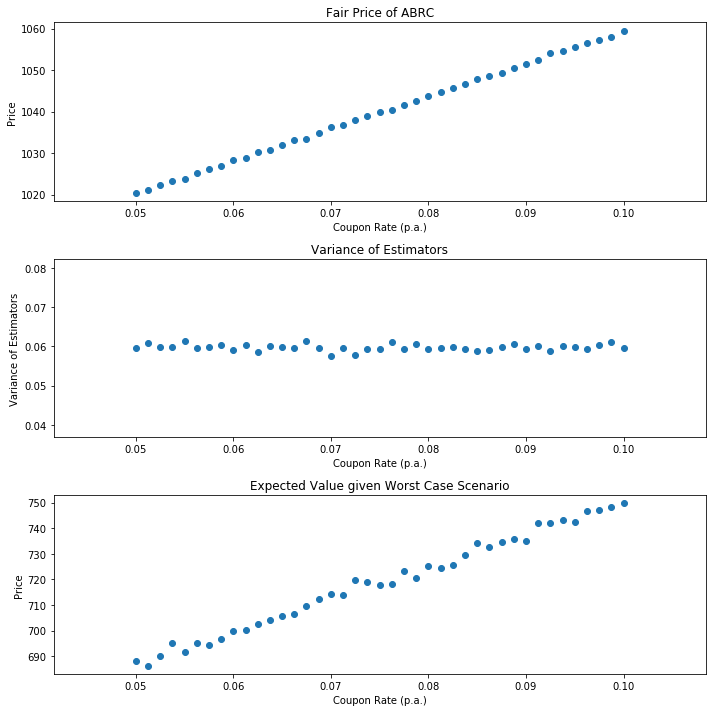

In [353]:
fig,axes = plt.subplots(3,1,figsize=(10,10))

axes[0].scatter(coupons,prices)
axes[0].set_ylabel('Price')
axes[0].set_title('Fair Price of ABRC')
axes[1].scatter(coupons,variances)
axes[1].set_ylabel('Variance of Estimators')
axes[1].set_title('Variance of Estimators')
axes[2].scatter(coupons,worst_value)
axes[2].set_ylabel('Price')
axes[2].set_title('Expected Value given Worst Case Scenario')

for i in range(3):
    axes[i].set_xlabel('Coupon Rate (p.a.)')
    
plt.tight_layout()

# Stress Testing

In [357]:
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
trans = 0.0005 # transaction fee

def ABRC_stress(pr,level=[0,0]):
    N = 10**5
    S1 = np.ones((T-1,N))*cat.iloc[-1,0]
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    r = np.ones((T-2,N))*rate[-1]
    Z1 = np.random.normal(0,1,size=(T-2,N))
    Z2 = np.random.normal(0,1,size=(T-2,N))
    Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
    Zr = np.random.normal(0,1,size=(T-2,N)) # for CIR
    # increase stock volatility
    sigma1 = sig1*level[0]
    sigma2 = sig2*level[0]
    W1,W2,W3,W4 = np.random.normal(0,0.01*(1+level[0]),N),np.random.normal(0,0.01*(1+level[0]),N),np.random.normal(0,0.01*(1+level[0]),N),np.random.normal(0,0.01*(1+level[0]),N)
    # increase interest rate volatility
    sigma = sig*level[1]

    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-r[i,:]-0.5*sigma1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-r[i,:]-0.5*sigma2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
        r[i+1,:] = r[i,:]+alpha*(mu-np.maximum(r[i,:],0))*dt+sigma*np.sqrt(np.maximum(r[i,:],0)*dt)*Zr[i,:]
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-r[-2,:]-0.5*sigma1**2)*dt+sig1*np.sqrt(dt)*Z1[-2,:])
    S2[-1,:] = S2[-2,:]*np.exp((mu2-r[-2,:]-0.5*sigma2**2)*dt+sig2*np.sqrt(dt)*Z2[-2,:])
    # adjustment from daily lowest prices to settlement prices
    S1[-1,:] *= 1+abs(W1)
    S2[-1,:] *= 1+abs(W2)
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+abs(W3)
    S2[-2,:] *= 1+abs(W4)
    
    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # (used to identify the redemption type for each simulation)
    early_index = np.zeros((3,N))

    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # trading days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to Trigger Redemption Date, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # get the index of early redemption at this date
            early_index[cp_date.index(early_rdp(date))-1,:] = np.logical_and(rdp==F,condition)
            # discount factor from today to Trigger Redemption Date 
            discount = np.exp(-(dts[:i]@r[:i,:])*(1/360)-r[i,:]*interval([date,early_rdp(date)])) 
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*discount, 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*discount, rdp), rdp)
        # if the date is an Interest Payment Date which is a Trigger Redemption Date
        elif date in early_cp:
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)
        # if the date is an Interest Payment Date which is not a Trigger Redemption Date
        else:
            i = np.busday_count(today,date,holidays=holidays)
            discount = np.exp(-(dts[:i]@r[:i,:])*(1/360))
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)

    # update the values at maturity
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2) 
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    # index of simulations with final redemption
    final = (rdp==F)
    
    discount = np.exp(-(dts@r)*(1/360))
    worst_payoff = np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    # condition of each redemption type
    early = np.array([list(map(bool,early_index[0])),
                       list(map(bool,early_index[1])),
                       list(map(bool,early_index[2]))])
    
    worst = np.logical_and.reduce([final,barrier,np.logical_not(barrier_full)])
    ok = np.logical_and(final,np.logical_not(worst))
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F, worst_payoff), F)*discount, rdp)
    
    total = rdp+cp

    p_early = np.mean(total[early.sum(axis=0)])
    p_final = np.mean(total[final])
    p_ok = np.mean(total[ok])
    p_worst = np.mean(total[worst])
    pb_worst = len(worst)/N
    
    price = total.mean()
    var = np.var(total,ddof=1)/N

    return(price,var,p_early,p_final,p_ok,p_worst,pb_worst)



In [358]:
# stress function that returns characteristics of ABRC given coupon rate and stress level 
stress = lambda x: ABRC_stress(pr=x[0],level=[x[1],x[2]])

param = np.mgrid[0.05:0.1025:0.0025, 0:1.1:0.1, 0:1.1:0.1].reshape(3,-1).T
result = np.array(list(map(stress,param)))
# result is a M by 4 matrix where each row is a vector 
# [fair price,variance of estimator, probability of Worst Case Scenario, expected value given Worst Case Scenario]
# M = a*b is the size of parameters where a: number of coupon rates, b: number of stress levels

KeyboardInterrupt: 

 Vectorized stress testing function

In [161]:
from math import floor
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
pr = 0.0825 # coupon rate
R1, R2 = 4.3388, 2.6733 # ratio of worst case scenario
trans = 0.0005 # transaction fee

def ABRC_stress(pr=0.0825, r0=rate[-1], CIR=np.array([alpha,mu,sig]), level_stock = np.zeros(1), level_rate = np.zeros(1), N=10**3):
    '''
    pr: scalar of coupon rate p.a.
    r0: scalar of initial level of risk-free rate
    CIR: array-like object that specifies the parameter of CIR model for risk-free rate
         with the format CIR = [alpha,mu,sig]
    level_stock: 1d array-like object of stress levels for stock volatility. Default to zero (no stress)
    level_rate: 1d array-like object of stress levels for interest rate volatility. Default to zero (no stress)
    N: number of simulations. Default to 1000
    
    '''
    if CIR is not None:
        alpha, mu, sig = CIR
    
    # number of stress levels
    M = len(level_stock)
    P = len(level_rate)    
#     N = 10**5
    S1 = np.ones((T-1,N,M,P))*cat.iloc[-1,0]
    S2 = np.ones((T-1,N,M,P))*de.iloc[-1,0]
    r = np.ones((T-2,N,M,P))*r0
    Z1 = np.random.normal(0,1,size=(T-2,N,M,P))
    Z2 = np.random.normal(0,1,size=(T-2,N,M,P))
    Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
    Zr = np.random.normal(0,1,size=(T-2,N,M,P)) # for CIR
    # increase stock volatility
    sigma1, sigma2 = np.zeros((N,M,P)), np.zeros((N,M,P)) # N by M by P matrix where y-axis is a copy of stress level of stock volatility
    for i in range(P):
        sigma1[:,:,i] = np.repeat(np.array([sig1*(1+level_stock)]), N, axis=0)
    for i in range(P):
        sigma2[:,:,i] = np.repeat(np.array([sig2*(1+level_stock)]), N, axis=0)
    W = np.zeros((4,N,M,P))
    for i in range(4):
        for j in range(P):
            W[i,:,:,j] = np.random.normal(0,0.01*(1+level_stock),(N,M))
    # increase interest rate volatility
    sigma = np.zeros((N,M,P))
    for i in range(M):
        sigma[:,i,:] = np.repeat(np.array([sig*(1+level_rate)]), N, axis=0)
    dt = 1/360
    for i in range(T-3):
        S1[i+1]=S1[i]*np.exp((mu1-0.5*sigma1**2)*dt+sigma1*np.sqrt(dt)*Z1[i])
        S2[i+1]=S2[i]*np.exp((mu2-0.5*sigma2**2)*dt+sigma2*np.sqrt(dt)*Z2[i])
        r[i+1] = r[i]+alpha*(mu-np.maximum(r[i],0))*dt+sigma*np.sqrt(np.maximum(r[i],0)*dt)*Zr[i]
    # daily lowest price at maturity
    dt = 3/360
    S1[-1] = S1[-2]*np.exp((mu1-r[-2]-0.5*sigma1**2)*dt+sigma1*np.sqrt(dt)*Z1[-2])
    S2[-1] = S2[-2]*np.exp((mu2-r[-2]-0.5*sigma2**2)*dt+sigma2*np.sqrt(dt)*Z2[-2])
    r[-1] = r[-2]+alpha*(mu-np.maximum(r[-2],0))*dt+sigma*np.sqrt(np.maximum(r[-2],0)*dt)*Zr[-2]
    # adjustment from daily lowest prices to settlement prices
    S1[-1] *= 1+np.absolute(W[0])
    S2[-1] *= 1+np.absolute(W[1])
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2] *= 1+np.absolute(W[2])
    S2[-2] *= 1+np.absolute(W[3])
    
    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones((N,M,P))*F, np.zeros((N,M,P))
    # indicators of type of early redemption 
    early = np.zeros((3,N,M,P))
    # discount factor for each simulation and stress levels
    discount = np.zeros((N,M,P))

    # update the values chronologically
    for date in sorted_date[:-1]:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # trading days from today to this TOD
            j = np.busday_count(today,early_rdp(date),holidays=holidays) # trading days from today to Trigger Redemption Date
            t = daycount(early_rdp(date)) # days from today to Trigger Redemption Date, excluding holiday
            condition = np.logical_and(S1[i]>=X1, S2[i]>=X2) # condition of early redemption
            # get the index of early redemption at this date
            early[cp_date.index(early_rdp(date))-1] = np.logical_and(rdp==F,condition)
            # discount factor from today to Trigger Redemption Date
            for m in range(M):
                for p in range(P):
                    discount[:,m,p] = np.exp((-dts[:,:j]@r[:j,:,m,p]*(1/360))[0]) 
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*discount, 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*discount, rdp), rdp)
        # if the date is an Interest Payment Date which is a Trigger Redemption Date
        elif date in early_cp:
            continue
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)
        # if the date is an Interest Payment Date which is not a Trigger Redemption Date
        else:
            i = np.busday_count(today,date,holidays=holidays)
            for m in range(M):
                for p in range(P):
                    discount[:,m,p] = np.exp((-dts[:,:i]@r[:i,:,m,p]*(1/360))[0])
            cp += np.where(rdp==F, F*0.25*pr*discount, 0)

    # update the values at maturity
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1],axis=0)<=B1, np.min(S2[:-1],axis=0)<=B2) 
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2]>=X1, S2[-2]>=X2])
    # index of simulations with final redemption
    final = (rdp==F)
    
    worst = np.logical_and.reduce([final,barrier,np.logical_not(barrier_full)])
    ok = np.logical_and(final,np.logical_not(worst))
    # discount factor at final redemption
    for m in range(M):
        for p in range(P):
            discount[:,m,p] = np.exp((-dts@r[:,:,m,p]*(1/360))[0])
    worst_payoff = np.where(S1[-2]/X1<=S2[-2]/X2, (R1-floor(R1))*S1[-2]+floor(R1)*S1[-1]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2]+floor(R2)*S2[-1]-trans*X2*R2)
    cp += np.where(rdp==F, F*0.25*pr*discount, 0)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F, worst_payoff), F)*discount, rdp)
    
    total = rdp+cp
    early = early.astype(bool)
#     p_early = np.mean(total[early.sum(axis=0)],axis=0)
#     p_final = np.mean(total[final],axis=0)
#     p_ok = np.mean(total[ok],axis=0)
    
    p_worst = np.zeros((M,P))
#     var = np.zeros((M,P))
    # expected value of worst case scenario
    for m in range(M):
        for p in range(P):
            p_worst[m,p] = np.mean(total[worst[:,m,p],m,p])
#             var[m,p] = np.var(total[:,m,p],ddof=1)/N
    # probability of worst case scenario
    pb_worst = worst.sum(axis=0)/N
    
    price = total.mean(axis=0)

    return(price,p_worst,pb_worst)
# ,p_early,p_final,p_ok


In [160]:
a,b,c = np.array([1,2,3])
a

1

In [162]:
test = ABRC_stress(pr=0.0825, r0=0.005, CIR=[alpha,mu*1.2,sig], level_stock = stress_stock, level_rate = stress_rate, N=1000)

In [157]:
# stress function that returns characteristics of ABRC given coupon rate and stress level 
# param = np.mgrid[0.05:0.11:0.01, 0:1.2:0.2, 0:1.2:0.2].reshape(3,-1).T
stress_stock = np.linspace(0,1,21)
stress_rate = np.linspace(0,1,21)
# result = ABRC_stress(pr=0.0825, level_stock = stress_stock, level_rate = stress_rate, N=1000)
fair_price = np.zeros((21,21))
ev_worst = np.zeros((21,21))
pb_worst = np.zeros((21,21))
for i in range(10):
    result = ABRC_stress(pr=0.0825, r0=0.002, level_stock = stress_stock, level_rate = stress_rate, N=1000)
    fair_price += result[0]
    ev_worst += result[1]
    pb_worst += result[2]
    

fair_price = price/10
pb_worst = pb_worst/10
ev_worst = ev_worst/10


# result is a M by 4 matrix where each row is a vector 
# [fair price,variance of estimator, probability of Worst Case Scenario, expected value given Worst Case Scenario]
# M = a*b is the size of parameters where a: number of coupon rates, b: number of stress levels

In [151]:
hey = ABRC_stress(level_stock=np.linspace(0,0.1,3),level_rate=np.linspace(0,0.1,3),N=10000)
hey[2]

array([[0.0437, 0.0453, 0.0452],
       [0.0579, 0.0541, 0.0552],
       [0.0719, 0.0717, 0.0785]])

In [150]:
ev_worst

array([[664.09019544, 665.36231857, 657.87914963, 664.27358176,
        665.90049528, 666.47885551, 656.45140464, 664.7542822 ,
        664.20729194, 667.19894095, 669.0882098 , 666.3599718 ,
        663.17760455, 668.27430692, 667.15679505, 671.04028099,
        661.07337432, 677.01507573, 660.01222723, 671.11417602,
        665.46703673],
       [672.09135742, 662.07069309, 665.81707653, 664.98513593,
        667.33199931, 665.76891014, 669.2899754 , 670.99005728,
        662.43035206, 668.4517032 , 666.71557043, 667.496882  ,
        672.58095549, 670.31478747, 671.54960673, 669.35925416,
        671.69481009, 671.3618293 , 653.99975721, 668.15028739,
        663.46942939],
       [673.71292814, 662.56902335, 663.28875549, 664.47179223,
        660.1350104 , 660.18543816, 662.45792409, 666.4090245 ,
        666.72689597, 668.66663978, 667.55203457, 656.37184751,
        665.04692725, 670.26626988, 662.0700985 , 670.04191   ,
        665.13466396, 671.27415859, 659.48369447, 663.5034

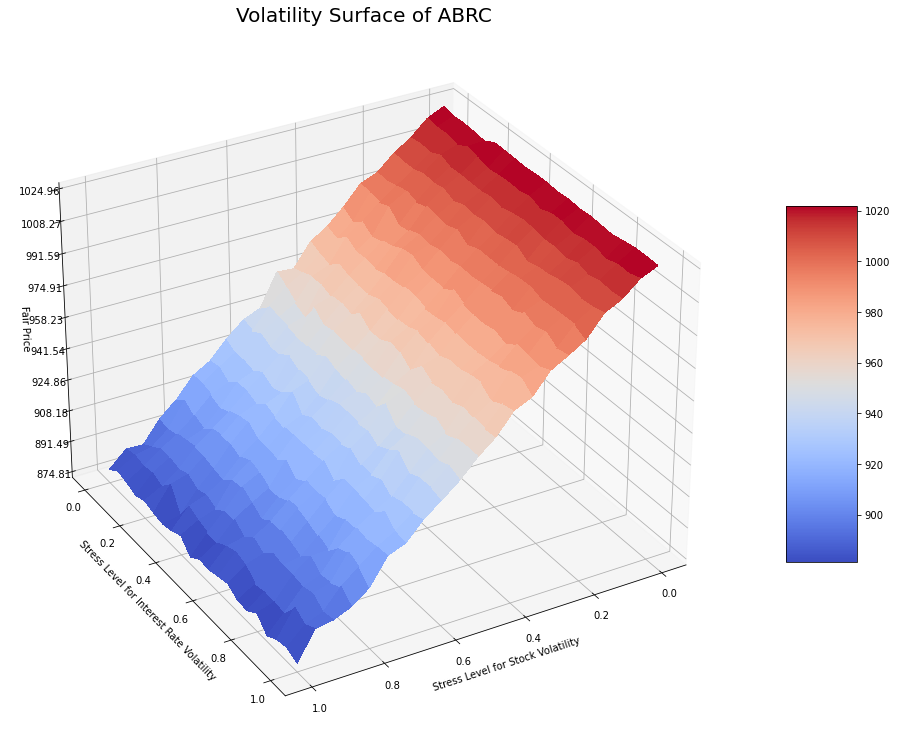

In [57]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(projection='3d')

X = stress_stock
Y = stress_rate
Y, X = np.meshgrid(X, Y)

# surf = ax.plot_surface(stress_stock, stress_rate, fair_price, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, fair_price, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Stress Level for Stock Volatility')
ax.set_ylabel('Stress Level for Interest Rate Volatility')

ax.set_zlabel('Fair Price')
ax.set_zticks([])
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(30, 60)
ax.set_title('Volatility Surface of ABRC', loc='center',fontsize= 20)
fig.tight_layout()

plt.show()


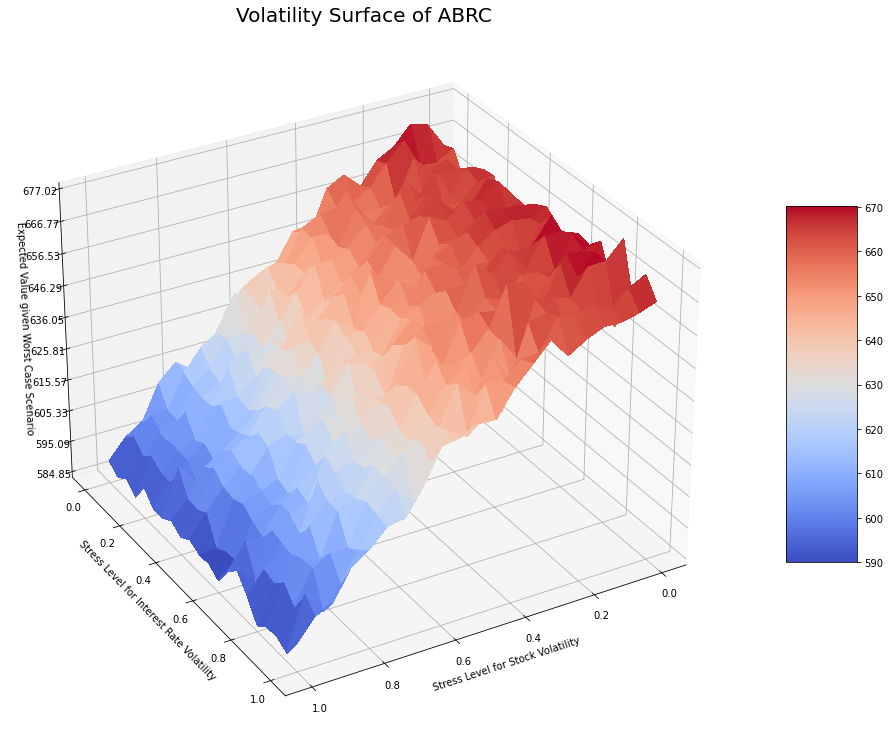

In [149]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(projection='3d')

X = stress_stock
Y = stress_rate
Y, X = np.meshgrid(X, Y)

# surf = ax.plot_surface(stress_stock, stress_rate, fair_price, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, ev_worst, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Stress Level for Stock Volatility')
ax.set_ylabel('Stress Level for Interest Rate Volatility')

ax.set_zlabel('Expected Value given Worst Case Scenario')
ax.set_zticks([])
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(30, 60)
ax.set_title('Volatility Surface of ABRC', loc='center',fontsize= 20)
fig.tight_layout()

plt.show()


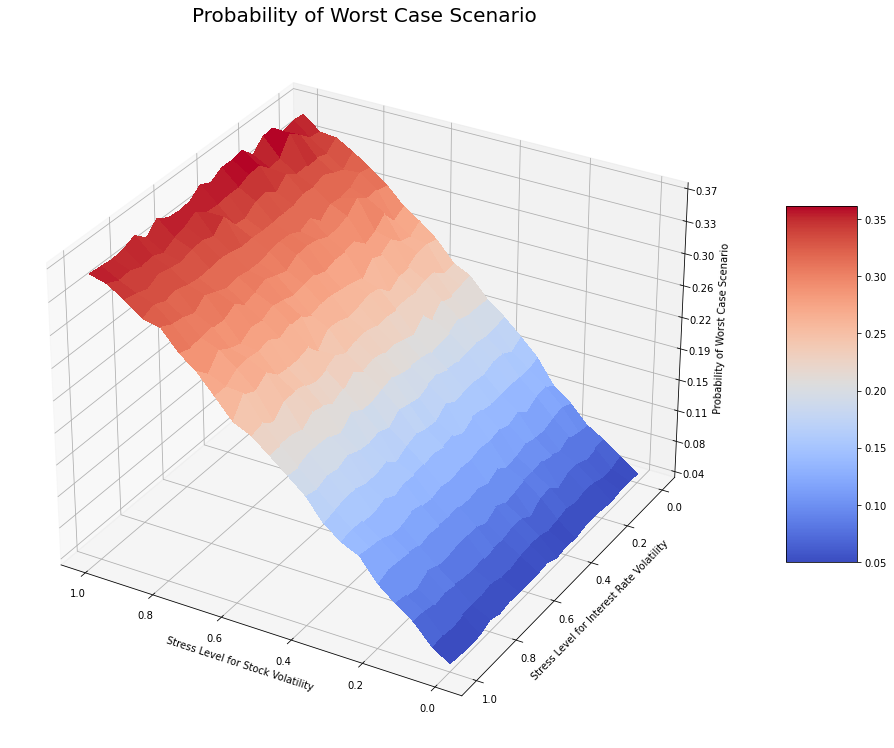

In [155]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(projection='3d')

X = stress_stock
Y = stress_rate
Y, X = np.meshgrid(X, Y)

# surf = ax.plot_surface(stress_stock, stress_rate, fair_price, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, pb_worst, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Stress Level for Stock Volatility')
ax.set_ylabel('Stress Level for Interest Rate Volatility')

ax.set_zlabel('Probability of Worst Case Scenario')
ax.set_zticks([])
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(30, 120)
ax.set_title('Probability of Worst Case Scenario', loc='center',fontsize= 20)
fig.tight_layout()

plt.show()


In [46]:
ev_worst

array([[952.47051811, 952.55853203, 951.82047808, 953.11883408,
        952.68487276, 952.789034  , 952.4170504 , 953.06711596,
        952.23475566, 952.19510279, 952.79000511, 952.91349272,
        953.34537463, 951.61161248, 953.00078036, 952.01483663,
        952.32075479, 952.67839291, 952.17531359, 952.34559032,
        953.18438333],
       [951.68078976, 952.21013722, 952.12839535, 952.59740401,
        953.00213603, 952.58441999, 952.59812087, 953.44816518,
        952.31155384, 952.85584503, 952.53528922, 952.46315909,
        952.56975363, 952.46780819, 952.68676128, 952.87778096,
        953.13140848, 952.74002708, 952.39004733, 952.96426787,
        953.55058699],
       [952.54455302, 952.81749268, 952.55440908, 952.85245201,
        952.38612617, 952.64515959, 952.9121256 , 952.34023016,
        952.73075124, 953.10836267, 952.56360553, 952.75954737,
        953.17636726, 953.05685298, 952.62262059, 952.76280509,
        952.21479356, 953.06975135, 952.97685914, 953.0153

In [97]:
# param = np.mgrid[0:1.1:0.1, 0:1.1:0.1].reshape(2,-1).T
# triple = np.concatenate((param,fair_price.T),axis=1)
# triple

param = np.mgrid[0:1.05:0.05, 0:1.05:0.05].reshape(2,-1).T
price = fair_price.reshape(1,441)
triple = np.concatenate((param,price.T),axis=1) # (stress level for stock, stress level for interest rate, fair price)
# triple2 = np.concatenate((param,ev_worst.T),axis=1)

Xs

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. ])

In [612]:
result[0]

array([[1026.47516778, 1027.27849568, 1018.61494707, 1023.56003602,
        1021.52830335, 1024.22162678, 1023.935356  , 1024.03391847,
        1024.66110968, 1023.76983291, 1026.39144249],
       [1008.48526981, 1016.64239097, 1012.78767615, 1013.20182133,
        1010.13084163, 1010.94375289, 1009.26116226, 1014.95176646,
        1017.46676352, 1015.06951113, 1012.81814852],
       [ 997.74907126,  993.73307686, 1001.01458257,  998.8891157 ,
        1004.85978503,  999.13112414,  999.51456757,  997.33476238,
        1002.4137936 ,  991.5456728 , 1001.79676099],
       [ 988.87680177,  989.18277535,  985.73436364,  982.69555557,
         981.08671126,  987.91193281,  981.93629495,  974.8970296 ,
         990.09325958,  982.6134844 ,  982.29967274],
       [ 968.13050552,  973.57831154,  972.08917019,  960.46408071,
         965.07744844,  973.58359021,  969.75896229,  973.49473036,
         972.64711164,  973.85548736,  969.35922337],
       [ 953.27067336,  960.46442403,  949.9066379

# Control Variate

In [520]:
# We use the ABRC on only CAT as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S1[i,:]>=X1) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S1[:-1,:],axis=0)<=B1
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S1[-2,:]>=X1)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

Correlation between Product and ABRC with CAT: 0.916361246668472
ABRC price by control variate: 1045.9308
variance of the estimator: 0.0096


In [517]:
# We use the ABRC on only DE as the known statistics in control variate
# Here the ABRC has all the same conditions except there's only one underlying

rdp1, cp1 = np.ones(N)*F, np.zeros(N)
# update the values chronologically
for date in sorted_date:
    # if the date is a Trigger Observation Date
    if date in rdp_date:
        i = daycount(date) # business days from today to this TOD
        t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
        condition = (S2[i,:]>=X2) # condition of early redemption
        # if rdp1==F, the simulated path has not been early redeemed at this TOD
        # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
        cp1 += np.where(rdp1==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
        rdp1 = np.where(rdp1==F, np.where(condition, rdp1*np.exp(-r*t/360), rdp1), rdp1)
    else:
        t = daycount(date)
        cp1 += np.where(rdp1==F, F*0.25*pr*np.exp(-r*t/360), 0)
# update the values at maturity
# condition of Barrier Event
barrier = np.min(S2[:-1,:],axis=0)<=B2
# condition of Barrier Event with full redemption at maturity
barrier_full = np.logical_and(barrier, S2[-2,:]>=X2)
t = daycount(cp_date[-1]) # time to maturity (days)
worst_payoff = np.exp(-r*t/360)*(R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2
rdp1 = np.where(rdp1==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp1)

values = cp1 + rdp1
print('Correlation between Product and ABRC with CAT:', np.corrcoef(total,values)[0,1])
b = np.corrcoef(total,values)[0,1]*np.std(total)/np.std(values)
print('ABRC price by control variate:', round(np.mean(total-b*(values-np.mean(values))),4))
print('variance of the estimator:', round(np.var(total-b*(values-np.mean(values)),ddof=1)/N,4))

Correlation between Product and ABRC with CAT: 0.5061438276165394
ABRC price by control variate: 1045.9623
variance of the estimator: 0.0439


# Antithetic variate

In [665]:
# face value
F = 1000
# strike price
X1 = 230.48
X2 = 374.07
# barrier price
B1 = X1*0.59
B2 = X2*0.59
# interest rate
r = 0.0023

N = 5*10**4
S1 = np.ones((T-1,N))*cat.iloc[-1,0]
S2 = np.ones((T-1,N))*de.iloc[-1,0]
Z1 = np.random.normal(0,1,size=(T-2,N))
Z2 = np.random.normal(0,1,size=(T-2,N))
Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
W1,W2,W3,W4 = np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01),np.random.normal(0,0.01)
trans = 0.0005 # transaction fee

def ABRC(pr,Z1,Z2):
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sig2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sig1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+abs(W1)
    S2[-1,:] *= 1+abs(W2)
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+abs(W3)
    S2[-2,:] *= 1+abs(W4)

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    rdp2 = rdp.copy() 
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    total = rdp+cp
    
    final_index = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations that reach final redemption
    pb_final = len(final_index[0])/N
    ev_final = np.mean(total[final_index]) # expected value of worst case scenario
    
    worst_index = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations for worst case scenario
    pb_worst = len(worst_index[0])/N
    ev_worst = np.mean(total[worst_index]) # expected value of final redemption
    
    summary = {'Probability of Final Redemption':round(pb_final,2), 'Expected Value of Final Redemption':round(ev_final,2),
               'Probability of Worst Case Scenario':round(pb_worst,3), 'Expected Value of Worst Case Scenario':round(ev_worst,2)}
    return(total, summary)

first = ABRC(pr=pr,Z1=Z1,Z2=Z2)
second = ABRC(pr=pr,Z1=Z1,Z2=-Z2)
prices1 = first[0]
prices2 = second[0]
corr = np.corrcoef(prices1,prices2)[0,1]
prices = np.concatenate((prices1,prices2))

print('Correlation between antithetic simulations:', corr)
print('ABRC price by antithetic variate:', np.mean(prices))
print('Variance of estimators:', np.var(prices,ddof=1)/len(prices))

# coupons = np.linspace(0.05,0.1,num=41)
# result = [ABRC(x) for x in coupons]

Correlation between antithetic simulations: 0.8996827601081229
ABRC price by antithetic variate: 1053.5488191342426
Variance of estimators: 0.05138353149207976


In [666]:
# comparison of antithetic simulations
print(np.mean(prices1), np.mean(prices2))
print(first[1])
print(second[1])

1048.7523473237377 1058.3452909447478
{'Probability of Final Redemption': 0.29, 'Expected Value of Final Redemption': 1052.42, 'Probability of Worst Case Scenario': 0.042, 'Expected Value of Worst Case Scenario': 777.41}
{'Probability of Final Redemption': 0.42, 'Expected Value of Final Redemption': 1065.04, 'Probability of Worst Case Scenario': 0.05, 'Expected Value of Worst Case Scenario': 804.71}


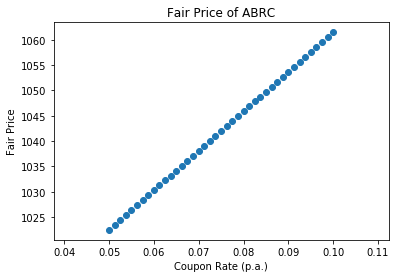

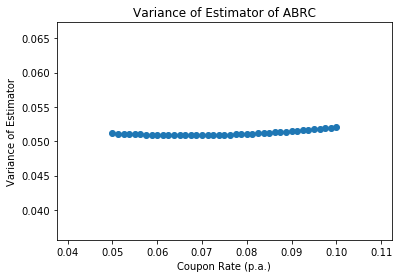

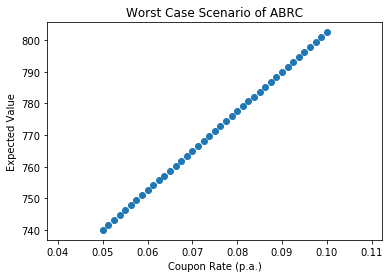

In [477]:
worst_value = [[i[5] for i in result]]

plt.scatter(coupons,worst_ev)
plt.title('Worst Case Scenario of ABRC')
plt.xlabel('Coupon Rate (p.a.)')
plt.ylabel('Expected Value')

# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\worst_coupon.png')

# Stress Testing

In [54]:
F = 1000 # face value
X1 = 230.48 # strike price
X2 = 374.07
B1 = X1*0.59 # barrier price
B2 = X2*0.59
r = 0.0023 # interest rate
trans = 0.0005 # transaction fee

def ABRC_stress(pr,level=0):
    N = 10**4
    S1 = np.ones((T-1,N))*cat.iloc[-1,0] # prices on Initial Fixing Date
    S2 = np.ones((T-1,N))*de.iloc[-1,0]
    sigma1 = sig1*(1+level) # increase the volatility terms in GBM by level 
    sigma2 = sig2*(1+level)
    
    Z1 = np.random.normal(0,1,size=(T-2,N))
    Z2 = np.random.normal(0,1,size=(T-2,N))
    Z2 = rho*Z1+np.sqrt(1-rho**2)*Z2
    # generate four normal r.v. for adjustment from daily lowest prices to final levels and settlement prices
    W1 = abs(np.random.normal(0,0.01*(1+level),N))
    W2 = abs(np.random.normal(0,0.01*(1+level),N))
    W3 = abs(np.random.normal(0,0.01*(1+level),N))
    W4 = abs(np.random.normal(0,0.01*(1+level),N))
    dt = 1/360
    for i in range(T-3):
        S1[i+1,:]=S1[i,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
        S2[i+1,:]=S2[i,:]*np.exp((mu2-0.5*sig2**2)*dt+sigma2*np.sqrt(dt)*Z2[i,:])
    # daily lowest price at maturity
    dt = 3/360
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
    S1[-1,:] = S1[-2,:]*np.exp((mu1-0.5*sig1**2)*dt+sigma1*np.sqrt(dt)*Z1[i,:])
    # as we are simulating daily lowest prices, we adjust the settlement price at maturity by some random number
    S1[-1,:] *= 1+W1
    S2[-1,:] *= 1+W2
    # adjustment for final level (from lowest prices to closing prices)
    S1[-2,:] *= 1+W3
    S2[-2,:] *= 1+W4

    # values of redemption and cumulative coupon payments for each simulation
    rdp, cp = np.ones(N)*F, np.zeros(N)
    # update the values chronologically
    for date in sorted_date:
        # if the date is a Trigger Observation Date
        if date in rdp_date:
            i = daycount(date) # business days from today to this TOD
            t = daycount(early_rdp(date)) # days from today to the next IPD, excluding holiday
            condition = np.logical_and(S1[i,:]>=X1, S2[i,:]>=X2) # condition of early redemption
            # if rdp==F, the simulated path has not been early redeemed at this TOD
            # add coupons if not redeemed earlier and meeting early redemption condition on this TOD
            cp += np.where(rdp==F, np.where(condition, F*0.25*pr*np.exp(-r*t/360), 0), 0) 
            rdp = np.where(rdp==F, np.where(condition, rdp*np.exp(-r*t/360), rdp), rdp)
        else:
            t = daycount(date)
            cp += np.where(rdp==F, F*0.25*pr*np.exp(-r*t/360), 0)
    # update the values at maturity
    # condition of Barrier Event
    barrier = np.logical_or(np.min(S1[:-1,:],axis=0)<=B1, np.min(S2[:-1,:],axis=0)<=B2)
    # condition of Barrier Event with full redemption at maturity
    barrier_full = np.logical_and.reduce([barrier, S1[-2,:]>=X1, S2[-2,:]>=X2])
    t = daycount(cp_date[-1]) # time to maturity (days)
    worst_payoff = np.exp(-r*t/360)*np.where(S1[-2,:]/X1<=S2[-2,:]/X2, (R1-floor(R1))*S1[-2,:]+floor(R1)*S1[-1,:]-trans*X1*R1 \
                                                    , (R2-floor(R2))*S2[-2,:]+floor(R2)*S2[-1,:]-trans*X2*R2)
    rdp = np.where(rdp==F, np.where(barrier, np.where(barrier_full, F*np.exp(-r*t/360), worst_payoff), F*np.exp(-r*t/360)), rdp)
    
    total = rdp+cp
    price = np.mean(total) # fair price
    var = np.var(total,ddof=1)/N # variance of estimator
    
    t = daycount(cp_date[-1]) # time to maturity (days)
    early = np.where(rdp>F*np.exp(-r*t/360)) # index of simulations with early redemption
    final = np.where(rdp<=F*np.exp(-r*t/360)) # index of simulations with final redemption
    ok = np.where(rdp==F*np.exp(-r*t/360)) # index of simulations with final redemption but no worst case scenario
    worst = np.where(rdp<F*np.exp(-r*t/360)) # index of simulations with worst case scenario
    
    p_early = len(early[0])/N
#     p_final = len(final[0])/N
#     p_ok = len(ok[0])/N
    p_worst = len(worst[0])/N
    
    ev_early = np.mean(total[early])
    ev_final = np.mean(total[final])
    ev_ok = np.mean(total[ok])
    ev_worst = np.mean(total[worst])
    
    return(price,var,p_worst,ev_worst,p_early,ev_early)



In [55]:
# stress function that returns characteristics of ABRC given coupon rate and stress level 
stress = lambda x: ABRC_stress(pr=x[0],level=x[1])

param = np.mgrid[0.05:0.1025:0.0025, 0:1.1:0.1].reshape(2,-1).T
result = np.array(list(map(stress,param)))
# result is a M by 4 matrix where each row is a vector 
# [fair price,variance of estimator, probability of Worst Case Scenario, expected value given Worst Case Scenario]
# M = a*b is the size of parameters where a: number of coupon rates, b: number of stress levels

In [56]:
fair_prices = np.array([[i[0] for i in result]])
ev_worst = np.array([[i[3] for i in result]])
triple = np.concatenate((param,fair_prices.T),axis=1) # (coupon, stress level, fair price)
triple2 = np.concatenate((param,ev_worst.T),axis=1)

array([[0.05  , 0.    ],
       [0.05  , 0.1   ],
       [0.05  , 0.2   ],
       [0.05  , 0.3   ],
       [0.05  , 0.4   ],
       [0.05  , 0.5   ],
       [0.05  , 0.6   ],
       [0.05  , 0.7   ],
       [0.05  , 0.8   ],
       [0.05  , 0.9   ],
       [0.05  , 1.    ],
       [0.0525, 0.    ],
       [0.0525, 0.1   ],
       [0.0525, 0.2   ],
       [0.0525, 0.3   ],
       [0.0525, 0.4   ],
       [0.0525, 0.5   ],
       [0.0525, 0.6   ],
       [0.0525, 0.7   ],
       [0.0525, 0.8   ],
       [0.0525, 0.9   ],
       [0.0525, 1.    ],
       [0.055 , 0.    ],
       [0.055 , 0.1   ],
       [0.055 , 0.2   ],
       [0.055 , 0.3   ],
       [0.055 , 0.4   ],
       [0.055 , 0.5   ],
       [0.055 , 0.6   ],
       [0.055 , 0.7   ],
       [0.055 , 0.8   ],
       [0.055 , 0.9   ],
       [0.055 , 1.    ],
       [0.0575, 0.    ],
       [0.0575, 0.1   ],
       [0.0575, 0.2   ],
       [0.0575, 0.3   ],
       [0.0575, 0.4   ],
       [0.0575, 0.5   ],
       [0.0575, 0.6   ],


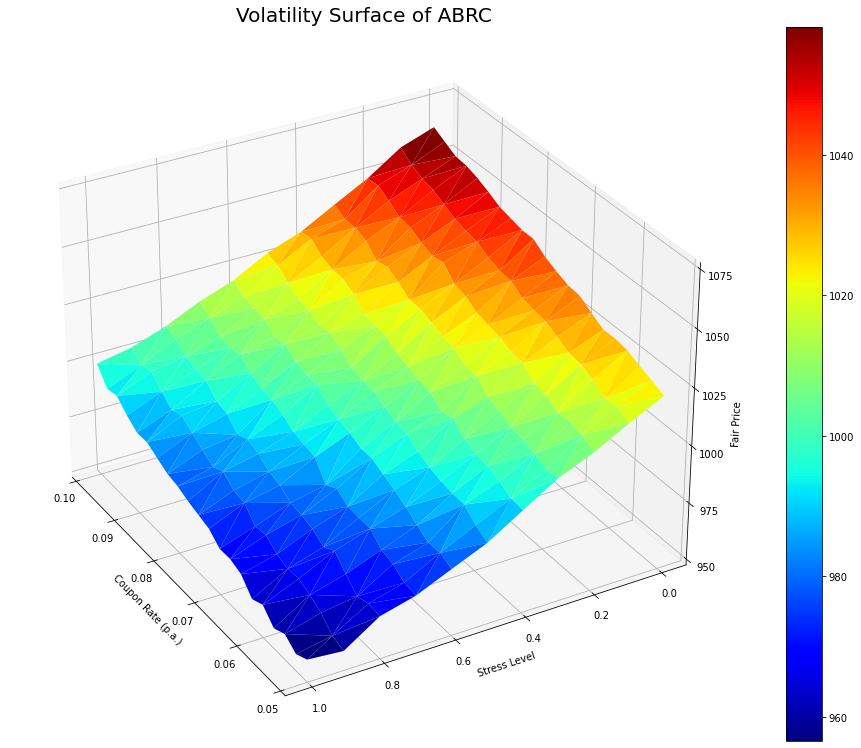

In [57]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')

Xs = triple[:,0]
Ys = triple[:,1]
Zs = triple[:,2]

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, ticks=np.linspace(960,1060,6))

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

ax.set_xlabel('Coupon Rate (p.a.)')
ax.set_ylabel('Stress Level')
ax.set_zlabel('Fair Price');

ax.set_xlim((0.05,0.1))
ax.set_zlim((950,1075))

ax.view_init(30, 150)
ax.set_title('Volatility Surface of ABRC', loc='center',fontsize= 20)
fig.tight_layout()

# plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\volatility_surface.png')

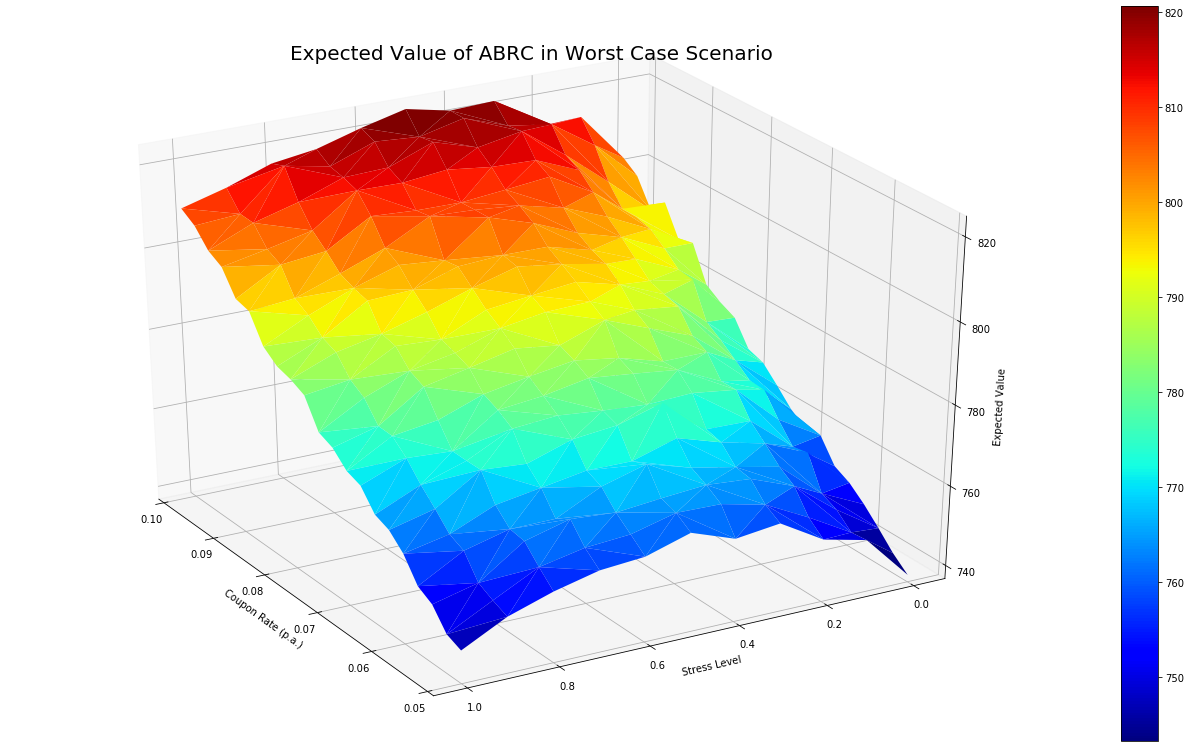

In [661]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')

Xs = triple2[:,0]
Ys = triple2[:,1]
Zs = triple2[:,2]

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

ax.set_xlabel('Coupon Rate (p.a.)')
ax.set_ylabel('Stress Level')
ax.set_zlabel('Expected Value');

ax.set_xlim((0.05,0.1))

ax.view_init(30, 150)
ax.set_title('Expected Value of ABRC in Worst Case Scenario', loc='center',fontsize= 20)
fig.tight_layout()

plt.show()
# plt.savefig('C:\\Users\\Euler Ou\\Dropbox\\NCSU\\2021 Spring\\FIM 548\\project\\worst_surface.png')